In [26]:
import pandas as pd
import paramiko
import os
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This notebook is for exploring the merged craigslist/census data and fitting some initial models.

TODO:
- parse dates and filter for date
- look at data from multiple states together
- add capability to create dataset for an MPO


## Remote connection parameters
If data is stored remotely

In [28]:
# TODO: add putty connection too. 

#read SSH connection parameters
with open('ssh_settings.json') as settings_file:    
    settings = json.load(settings_file)

hostname = settings['hostname']
username = settings['username']
password = settings['password']
local_key_dir = settings['local_key_dir']

census_dir = 'synthetic_population/'
"""Remote directory with census data"""

results_dir = 'craigslist_census/'
"""Remote directory for results"""

# estbalish SSH connection
ssh = paramiko.SSHClient() 
ssh.load_host_keys(local_key_dir)
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname,username=username, password=password)
sftp = ssh.open_sftp()

In [3]:
def read_listings_file(fname):
    """Read csv file via SFTP and return as dataframe."""
    with sftp.open(listings_dir+fname) as f:
        df = pd.read_csv(f, delimiter=',', dtype={'date':str,'fips_block':str,'state':str,'mpo_id':str})
        # TODO: parse dates. 
    return df

def log_var(x):
    """Return log of x, but NaN if zero."""
    if x==0:
        return np.nan
    else:
        return np.log(x)
    
def create_census_vars(df):
    """Make meaningful variables and return the dataframe."""
    df['pct_white'] = df['race_of_head_1']/df['hhs_tot']
    df['pct_black'] = df['race_of_head_2']/df['hhs_tot']
    df['pct_amer_native'] = df['race_of_head_3']/df['hhs_tot']
    df['pct_alaska_native'] = df['race_of_head_4']/df['hhs_tot']
    df['pct_any_native'] = df['race_of_head_5']/df['hhs_tot']
    df['pct_asian'] = df['race_of_head_6']/df['hhs_tot']
    df['pct_pacific'] = df['race_of_head_7']/df['hhs_tot']
    df['pct_other_race'] = df['race_of_head_8']/df['hhs_tot']
    df['pct_mixed_race'] = df['race_of_head_9']/df['hhs_tot']
    df['pct_mover'] = df['recent_mover_1']/df['hhs_tot']
    df['pct_owner'] = df['tenure_1']/df['hhs_tot']
    df['avg_hh_size'] = df['persons_tot']/df['hhs_tot']
    df['cars_per_hh'] = df['cars_tot']/df['hhs_tot']
    
    df['ln_rent'] = df['rent'].apply(log_var)
    df['ln_income'] = df.income_med.apply(log_var)
    return df

def filter_outliers(df, rent_range=(100,10000),sqft_range=(10,5000)):
    """Drop outliers from listings dataframe. For now, only need to filter out rent and sq ft. 
    Args: 
        df: Dataframe with listings. Cols names include ['rent','sqft']
        rent_range (tuple): min and max rent
        sqft_range (tuple): min and max sqft
    Returns: 
        DataFrame: listings data without outliers. 
    """
    n0=len(df)
    df=df[(df.rent>=rent_range[0])&(df.rent<rent_range[1])]
    n1=len(df)
    print('Dropped {} outside rent range ${}-${}'.format(n0-n1,rent_range[0],rent_range[1]))
    df=df[(df.sqft>=sqft_range[0])&(df.sqft<sqft_range[1])]
    n2=len(df)
    print('Dropped {} outside sqft range {}-{} sqft. {} rows remaining'.format(n1-n2,sqft_range[0],sqft_range[1],len(df)))
    return(df)

## Load data

In [4]:
# get list of files and load. 


# for remotely stored data by state (just do one state for now)
state='CA'
infile='cl_census_{}.csv'.format(state)
#data = read_listings_file(infile)  # uncomment to get remote data. 

# for local data: 
data_dir = '../data/'
data_file = 'sfbay_listings_03032017.csv'

data = pd.read_csv(data_dir+data_file,parse_dates=[1],dtype={'listing_id':str, 'rent':float, 'bedrooms':float, 'bathrooms':float, 'sqft':float,
       'rent_sqft':float, 'fips_block':str, 'state':str, 'region':str, 'mpo_id':str, 'lng':float, 'lat':float,
       'cars_tot':float, 'children_tot':float, 'persons_tot':float, 'workers_tot':float,
       'age_of_head_med':float, 'income_med':float, 'hhs_tot':float, 'race_of_head_1':float,
       'race_of_head_2':float, 'race_of_head_3':float, 'race_of_head_4':float, 'race_of_head_5':float,
       'race_of_head_6':float, 'race_of_head_7':float, 'race_of_head_8':float, 'race_of_head_9':float,
       'recent_mover_0':float, 'recent_mover_1':float, 'tenure_1':float, 'tenure_2':float})

print(len(data))
data.head()

82727


,listing_id,date,rent,bedrooms,bathrooms,sqft,rent_sqft,fips_block,state,region,...,race_of_head_4,race_of_head_5,race_of_head_6,race_of_head_7,race_of_head_8,race_of_head_9,recent_mover_0,recent_mover_1,tenure_1,tenure_2
0,5950749277,2017-01-08,3900,2,1.0,1000,3.900000,060750102001012,CA,sfbay,...,NaN,NaN,51,1,1,14,547,90,288,349
1,5930739630,2017-01-08,2107,2,1.5,1028,2.049611,060971506122048,CA,sfbay,...,NaN,NaN,11,2,19,19,536,25,264,297
2,5950748411,2017-01-08,3644,2,2.0,1362,2.675477,060855067033008,CA,sfbay,...,NaN,NaN,130,NaN,1,3,322,8,91,239
3,5950747869,2017-01-08,4350,2,1.0,900,4.833333,060750102001012,CA,sfbay,...,NaN,NaN,51,1,1,14,547,90,288,349
4,5950747694,2017-01-08,2450,3,2.0,1850,1.324324,060133270005038,CA,sfbay,...,NaN,1,27,2,16,25,634,25,547,112


In [5]:
# for census vars, NA really means 0...
census_cols = ['cars_tot', 'children_tot','persons_tot', 'workers_tot', 'age_of_head_med', 'income_med','hhs_tot', 'race_of_head_1', 'race_of_head_2', 'race_of_head_3','race_of_head_4', 'race_of_head_5', 'race_of_head_6', 'race_of_head_7','race_of_head_8', 'race_of_head_9', 'recent_mover_0', 'recent_mover_1','tenure_1', 'tenure_2']
for col in census_cols:
    data[col] = data[col].fillna(0)

## create variables
**variable codes**

Race codes (from PUMS)
1 .White alone
 2 .Black or African American alone
 3 .American Indian alone
 4 .Alaska Native alone
 5 .American Indian and Alaska Native tribes specified; or American
 .Indian or Alaska native, not specified and no other races
 6 .Asian alone
 7 .Native Hawaiian and Other Pacific Islander alone
 8 .Some other race alone
 9 .Two or more major race groups
 
 
 
 tenure_1 = owner (based on my guess; didn't match the PUMS codes)
 
 mover_1 = moved past year (based on my guess)

In [6]:
# create useful variables 
data = create_census_vars(data)

# define some feature to include in the model. 
features_to_examine = ['rent','ln_rent', 'bedrooms','bathrooms','sqft','pct_white', 'pct_black','pct_asian','pct_mover','pct_owner','income_med','age_of_head_med','avg_hh_size','cars_per_hh']
data[features_to_examine].describe()

,rent,ln_rent,bedrooms,bathrooms,sqft,pct_white,pct_black,pct_asian,pct_mover,pct_owner,income_med,age_of_head_med,avg_hh_size,cars_per_hh
count,8.272700e+04,82727.000000,82727.000000,21135.000000,82727.000000,82701.000000,82701.000000,82701.000000,82701.000000,82701.000000,82727.000000,82727.000000,82701.000000,82701.000000
mean,8.424425e+03,7.892339,1.786938,1.528507,1070.799352,0.614164,0.051737,0.251347,0.238773,0.444723,84269.025923,47.596722,2.392070,1.685853
std,8.079905e+05,0.415221,0.995156,0.658353,4395.502018,0.222690,0.100005,0.199291,0.134969,0.267616,35749.132951,7.469119,0.570091,0.477950
min,1.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119074,0.084123
25%,2.125000e+03,7.661527,1.000000,1.000000,716.000000,0.445419,0.000000,0.087121,0.130178,0.238063,58000.000000,42.000000,1.973294,1.422348
50%,2.600000e+03,7.863267,2.000000,1.000000,930.000000,0.625000,0.014629,0.210407,0.231550,0.438642,79630.000000,48.000000,2.348315,1.764550
75%,3.308000e+03,8.104099,2.000000,2.000000,1187.000000,0.791878,0.050829,0.383133,0.333826,0.643371,105000.000000,53.000000,2.776371,2.007761
max,2.100204e+08,19.162715,8.000000,6.500000,985024.000000,1.000000,0.940909,0.950382,0.782759,1.000000,267500.000000,78.000000,5.241071,2.890467


## Filter outliers


In [7]:
# I've already identified these ranges as good at exluding outliers
rent_range=(100,10000)
sqft_range=(10,5000)
data = filter_outliers(data, rent_range=rent_range, sqft_range=sqft_range)

Dropped 386 outside rent range $100-$10000
Dropped 107 outside sqft range 10-5000 sqft. 82234 rows remaining


(0, 10000)

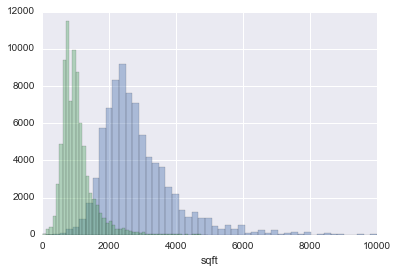

In [8]:
# Use this to explore outliers yourself. 
g=sns.distplot(data['rent'],  kde=False)
g.set_xlim(0,10000)

g=sns.distplot(data['sqft'], kde=False)
g.set_xlim(0,10000)

## Examine missing data

In [9]:
# examine NA's
print('Total rows:',len(data))
print('Rows with any NA:',len(data[pd.isnull(data).any(axis=1)]))
print('Rows with bathroom NA:',len(data[pd.isnull(data.bathrooms)]))
print('% rows missing bathroom col:',len(data[pd.isnull(data.bathrooms)])/len(data))

Total rows: 82234
Rows with any NA: 61242
Rows with bathroom NA: 61225
% rows missing bathroom col: 0.744521730671012


uh oh, 74% are missing bathrooms feature. Might have to omit that one. Only 0.02% of rows have other missing values, so that should be ok. 

Bathrooms were added in Dec sometime. If bathrooms aren't in the listing, the listing is thrown

In [10]:
# Uncomment to drop NA's
#data = data.dropna()
#print('Dropped {} rows with NAs'.format(n0-len(data)))

## Look at distributions

Since rent has a more or less logarithmic distribution, use ln_rent instead

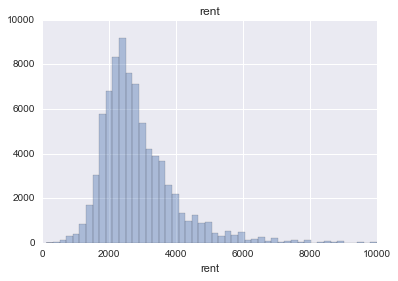

In [11]:
p=sns.distplot(data.rent, kde=False)
p.set_title('rent')

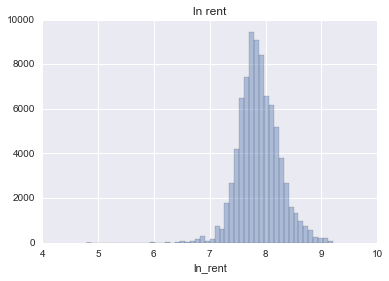

In [12]:
p=sns.distplot(data.ln_rent, kde=False)
p.set_title('ln rent')

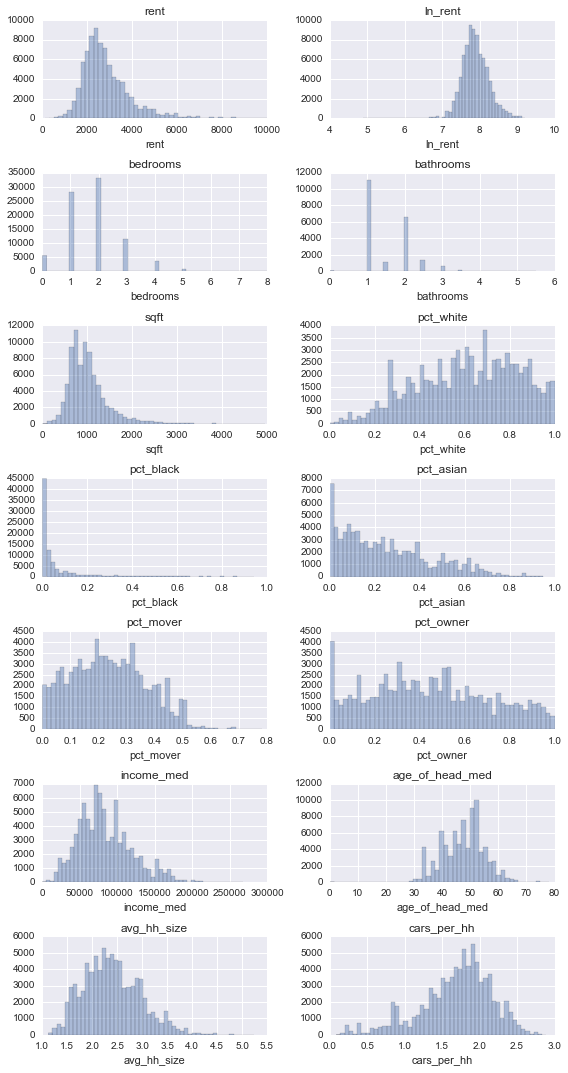

In [13]:
plot_rows = math.ceil(len(features_to_examine)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,15))
sns.despine(left=True)

for i,col in enumerate(features_to_examine):
    row_position = math.floor(i/2)
    col_position = i%2
    data_notnull = data[pd.notnull(data[col])]  # exclude NA values from plot
    sns.distplot(data_notnull[col], ax=axes[row_position, col_position],kde=False)
    axes[row_position, col_position].set_title('{}'.format(col)) 

plt.tight_layout()
plt.show()

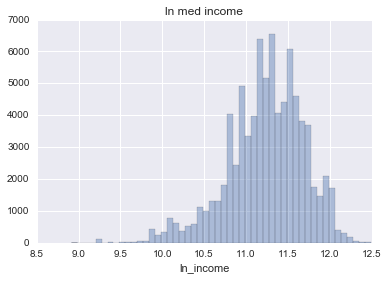

In [14]:
data_notnull = data[pd.notnull(data['ln_income'])]
p=sns.distplot(data_notnull['ln_income'],kde=False)
p.set_title('ln med income')
# ln med income is not more normal.. use med income instead. 

## look at correlations

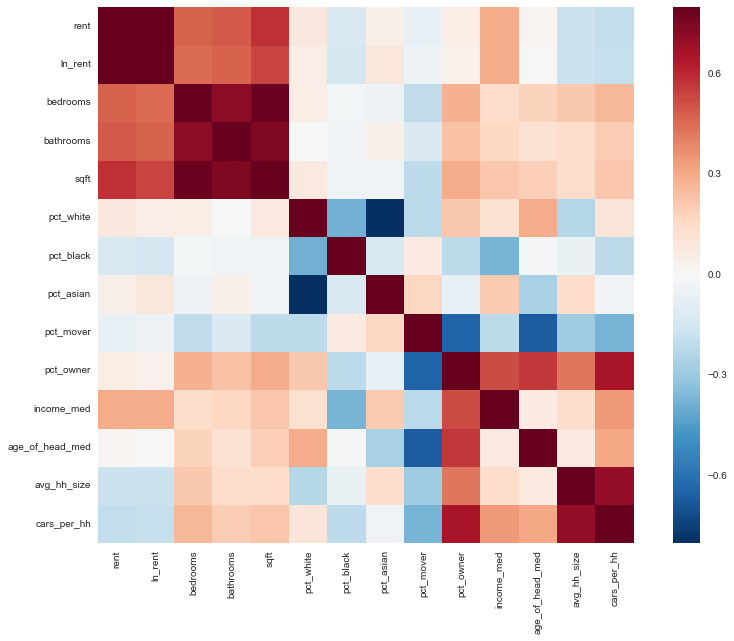

In [15]:
# correlation heatmap
corrmat=data[features_to_examine].corr()
corrmat.head()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

f.tight_layout()

The correlations appear as expected, except for cars_per_hh. Maybe this is because cars_per_hh is reflecting the size of the household more than income. Might want to try cars per adult instead..

## Try a linear model

In [16]:
from sklearn import linear_model, cross_validation

In [17]:
print(data.columns)
#'pct_amer_native','pct_alaska_native',
x_cols = ['bedrooms','bathrooms', 'sqft','age_of_head_med', 'income_med','pct_white', 'pct_black', 'pct_any_native', 'pct_asian', 'pct_pacific',
       'pct_other_race', 'pct_mixed_race', 'pct_mover', 'pct_owner', 'avg_hh_size', 'cars_per_hh']
y_col = 'ln_rent'
print(len(data))

Index(['listing_id', 'date', 'rent', 'bedrooms', 'bathrooms', 'sqft',
       'rent_sqft', 'fips_block', 'state', 'region', 'mpo_id', 'lng', 'lat',
       'cars_tot', 'children_tot', 'persons_tot', 'workers_tot',
       'age_of_head_med', 'income_med', 'hhs_tot', 'race_of_head_1',
       'race_of_head_2', 'race_of_head_3', 'race_of_head_4', 'race_of_head_5',
       'race_of_head_6', 'race_of_head_7', 'race_of_head_8', 'race_of_head_9',
       'recent_mover_0', 'recent_mover_1', 'tenure_1', 'tenure_2', 'pct_white',
       'pct_black', 'pct_amer_native', 'pct_alaska_native', 'pct_any_native',
       'pct_asian', 'pct_pacific', 'pct_other_race', 'pct_mixed_race',
       'pct_mover', 'pct_owner', 'avg_hh_size', 'cars_per_hh', 'ln_rent',
       'ln_income'],
      dtype='object')
82234


In [18]:
# create training and testing datasets. 

# exclude missing values
data_notnull= data[(pd.notnull(data[x_cols])).all(axis=1)]
data_notnull= data_notnull[(pd.notnull(data_notnull[y_col]))]
print('using {} rows of {} total'.format(len(data_notnull),len(data)))

# this creates a test set that is 30% of total obs.  
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_notnull[x_cols],data_notnull[y_col], test_size = .3, random_state = 201)

using 21006 rows of 82234 total


In [19]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# Intercept
print('Intercept:', regr.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(regr.coef_, index=x_cols)

Intercept: 3.79537239111
Coefficients:


bedrooms           0.080902
bathrooms          0.084796
sqft               0.000223
age_of_head_med    0.000365
income_med         0.000003
pct_white          4.054088
pct_black          3.653897
pct_any_native    -2.392451
pct_asian          4.183934
pct_pacific        6.300127
pct_other_race     4.882282
pct_mixed_race     3.472586
pct_mover         -0.154455
pct_owner         -0.078191
avg_hh_size       -0.060285
cars_per_hh       -0.334151
dtype: float64

In [21]:
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Mean squared error: 0.06
Variance score: 0.55


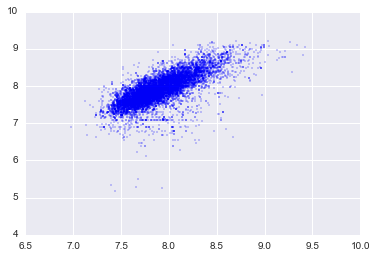

In [22]:
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

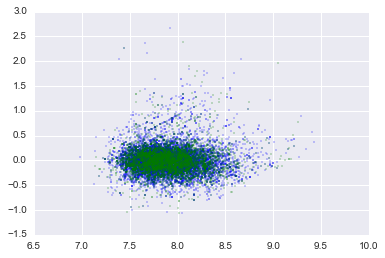

In [23]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

The residuals look pretty normally distributed.

I wonder if inclusion of all these race variables is leading to overfitting. If so, we'd have small error on training set and large error on test set. 

In [24]:
print("Training set. Mean squared error: %.5f" % np.mean((regr.predict(X_train) - y_train) ** 2), '| Variance score: %.5f' % regr.score(X_train, y_train))
print("Test set. Mean squared error: %.5f" % np.mean((regr.predict(X_test) - y_test) ** 2), '| Variance score: %.5f' % regr.score(X_test, y_test))

Training set. Mean squared error: 0.06211 | Variance score: 0.54432
Test set. Mean squared error: 0.06038 | Variance score: 0.54917


## Try Ridge Regression (linear regression with regularization )
Since the training error and test error are about the same, and since we're using few features, overfitting probably isn't a problem. If it were a problem, we would want to try a regression with regularization. 
Let's try it just for the sake of demonstration. 

In [24]:
from sklearn.linear_model import Ridge

In [25]:
# try a range of different regularization terms.
for a in [10,1,0.1,.01,.001,.00001]:
    ridgereg = Ridge(alpha=a)
    ridgereg.fit(X_train, y_train)
    
    print('\n alpha:',a)
    print("Mean squared error: %.5f" % np.mean((ridgereg.predict(X_test) - y_test) ** 2),'| Variance score: %.5f' % ridgereg.score(X_test, y_test))


 alpha: 10
Mean squared error: 0.06101 | Variance score: 0.54446

 alpha: 1
Mean squared error: 0.06070 | Variance score: 0.54678

 alpha: 0.1
Mean squared error: 0.06040 | Variance score: 0.54897

 alpha: 0.01
Mean squared error: 0.06035 | Variance score: 0.54936

 alpha: 0.001
Mean squared error: 0.06037 | Variance score: 0.54920

 alpha: 1e-05
Mean squared error: 0.06038 | Variance score: 0.54917


In [26]:

# Intercept
print('Intercept:', ridgereg.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(ridgereg.coef_, index=x_cols)

Intercept: 3.79611296526
Coefficients:


bedrooms           0.080902
bathrooms          0.084796
sqft               0.000223
age_of_head_med    0.000365
income_med         0.000003
pct_white          4.053343
pct_black          3.653153
pct_any_native    -2.392905
pct_asian          4.183189
pct_pacific        6.299132
pct_other_race     4.881522
pct_mixed_race     3.471789
pct_mover         -0.154453
pct_owner         -0.078191
avg_hh_size       -0.060284
cars_per_hh       -0.334152
dtype: float64

As expected, Ridge regression doesn't help much. 
The best way to improve the model at this point is probably to add more features. 

## ways to improve the model:
- add features. E.g., dummy vars for MPO, population density. Maybe date?
- at least filter for date
- other census variables (e.g., ACS building chars)
- try robust regression
- try RF, etc.

